In [132]:
%matplotlib inline

import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [2]:
!mkdir -p data

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


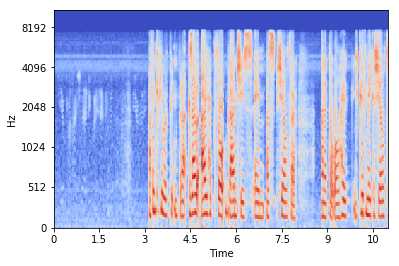

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

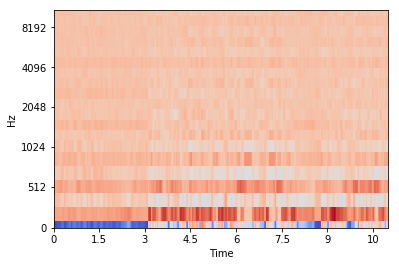

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

/home/maxim/PycharmProjects/speech-ml-hw/2/homework/laughter_classification/sspnet_data_sampler.py:111: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  return pd.DataFrame.from_csv(save_path, index_col=None)


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy.csv')

In [12]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-1.822273,-4.153107,-6.127165,-4.744270,-3.042214,-1.339390,3.440107,12.049357,18.508058,18.495235,...,-3.279198,-7.744685,13.188406,-15.828284,-2.788314,-6.735201,-0.648314,-2.205029,0,S0883
1,-15.560526,-12.192421,-17.653885,-19.870362,-14.625828,-18.043698,-17.459772,-15.043800,-15.155906,-14.942318,...,2.968277,-3.823424,7.782831,-10.649842,12.054846,-16.101373,7.706882,7.032740,0,S0883
2,-13.402336,-9.324762,-11.337922,-13.557925,-11.274661,-11.788429,-12.618071,-13.004464,-12.791547,-12.865611,...,10.503806,-3.110308,16.844341,-16.793098,9.245858,-12.490855,1.376820,-1.481758,0,S0883
3,-15.991697,-11.128731,-14.647389,-14.145352,-10.337301,-8.605968,-6.843310,-8.546107,-9.693120,-10.963831,...,15.545574,-3.590542,14.474457,-15.913445,2.790456,-15.866880,-1.439778,-4.094808,0,S0883
4,-16.955938,-13.346069,-15.512038,-17.894600,-18.070054,-17.828938,-16.749832,-16.722315,-19.911563,-19.673532,...,5.920388,-4.687736,15.792177,-13.221612,13.721047,-13.489680,9.807748,-2.527528,0,S0883
5,0.646691,-5.498471,-6.820034,-8.193006,-7.084161,-3.792549,-1.219193,11.592491,17.865859,15.925368,...,-2.049894,-14.379304,3.403395,-12.829240,2.768446,-5.736103,3.966473,0.461561,0,S0883
6,-6.284641,-4.476452,-4.508171,-5.953777,-6.800229,-4.671392,-0.456830,3.798520,3.489447,4.283108,...,7.559780,-1.081865,0.940473,-14.494771,1.262333,-2.956683,-4.423065,3.032808,0,S0883
7,-15.978457,-12.014055,-19.023314,-23.477487,-19.386470,-20.043930,-20.530321,-19.775818,-20.583855,-20.342087,...,12.887851,-2.703269,14.150279,-16.079925,19.098814,-9.557634,4.102285,-1.883761,0,S0883
8,-16.920980,-13.219841,-16.037795,-18.457891,-18.815624,-15.650121,-14.958242,-15.178341,-16.562365,-18.883285,...,1.705320,-2.482357,11.217743,-20.793836,9.347085,-12.347605,10.098329,-2.900409,0,S0883
9,-15.483795,-11.250385,-14.363998,-15.435853,-15.122773,-16.479205,-16.355765,-15.626713,-14.124518,-13.873653,...,9.564394,-11.874891,9.189812,-19.225750,9.891422,-9.940770,13.255929,-2.335170,0,S0883


In [76]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

In [77]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [78]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [79]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-18.279837,-9.925743,-7.034727,-6.366470,-3.582562,-1.967274,-2.186619,-2.898087,-3.289914,-0.819692,...,-1.169253,-17.384172,7.527737,-6.033273,7.701181,-23.957190,3.767768,1.823572,-9.087695,-6.310789
1,-8.350764,-5.838239,-12.176471,-14.766308,-9.684821,-6.898449,-8.555903,-6.893569,-8.804226,-9.584676,...,8.890739,-5.229507,-4.702625,0.386777,3.939774,-18.231355,2.193106,4.371894,9.123777,-3.683551
2,11.359923,12.165919,11.480765,10.722380,12.210117,10.033398,12.812613,19.312832,21.964445,20.846574,...,-4.888039,-7.816252,4.843390,-13.938502,14.086315,-21.263040,7.924920,-1.231396,-1.357336,-1.102332
3,9.336116,12.117546,12.854618,10.236182,10.263695,8.408460,15.811200,21.591474,21.708506,18.546723,...,-4.029900,-9.275778,2.575881,-9.233933,17.619638,-24.482254,1.947509,4.696934,-10.371555,-4.077387
4,-12.269389,-8.890475,-14.250389,-14.873047,-13.767618,-12.472830,-11.756094,-8.592509,-7.110627,-6.701631,...,11.078050,-9.460352,-4.329575,0.001802,15.019187,-29.359874,13.769583,1.476259,-5.777022,-4.519862


In [100]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [171]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [172]:
class LearningStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [181]:
model = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model = model.to(device)
model

stats = LearningStats()
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=0.02, stats=None):
    if stats is None:
        stats = LearningStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
    weight=torch.tensor([y_positive ** (-.1), 1]).to(device)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return roc_auc_score(y_actual.ravel(), y_score.ravel())
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return 2. / (1. / p + 1. / r)
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            
            
            stats.test_losses.append(test_loss)
            stats.train_losses.append(train_loss)
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 5 == 0:
            print("iter {} train_loss {:.5f} test_loss {:.5}".format(train_iter, train_losses[-1], test_losses[-1]))
        
        if train_iter % 50 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 5 train_loss 0.19826 test_loss 0.23156
iter 10 train_loss 0.19826 test_loss 0.23156
iter 15 train_loss 0.19826 test_loss 0.23156
iter 20 train_loss 0.19826 test_loss 0.23156
iter 25 train_loss 0.19826 test_loss 0.23156
iter 30 train_loss 0.19826 test_loss 0.23156
iter 35 train_loss 0.19826 test_loss 0.23156
iter 40 train_loss 0.19826 test_loss 0.23156
iter 45 train_loss 0.19826 test_loss 0.23156
iter 50 train_loss 0.19826 test_loss 0.23156


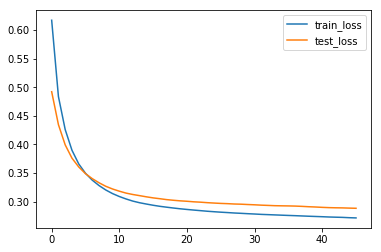

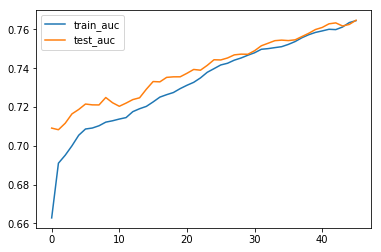

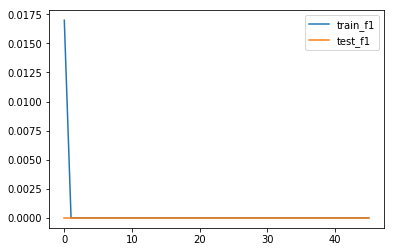

iter 55 train_loss 0.19826 test_loss 0.23156
iter 60 train_loss 0.19826 test_loss 0.23156
iter 65 train_loss 0.19826 test_loss 0.23156
iter 70 train_loss 0.19826 test_loss 0.23156
iter 75 train_loss 0.19826 test_loss 0.23156
iter 80 train_loss 0.19826 test_loss 0.23156
iter 85 train_loss 0.19826 test_loss 0.23156
iter 90 train_loss 0.19826 test_loss 0.23156
iter 95 train_loss 0.19826 test_loss 0.23156
iter 100 train_loss 0.19826 test_loss 0.23156


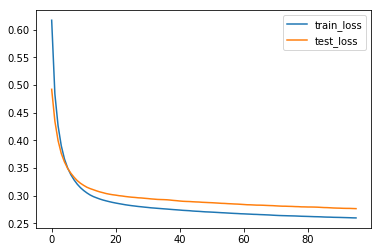

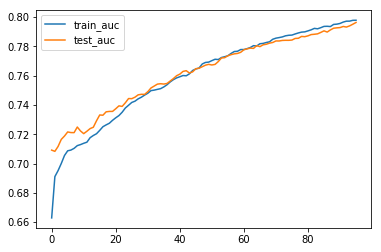

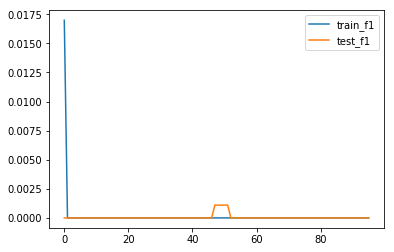

iter 105 train_loss 0.19826 test_loss 0.23156
iter 110 train_loss 0.19826 test_loss 0.23156
iter 115 train_loss 0.19826 test_loss 0.23156
iter 120 train_loss 0.19826 test_loss 0.23156
iter 125 train_loss 0.19826 test_loss 0.23156
iter 130 train_loss 0.19826 test_loss 0.23156
iter 135 train_loss 0.19826 test_loss 0.23156
iter 140 train_loss 0.19826 test_loss 0.23156
iter 145 train_loss 0.19826 test_loss 0.23156
iter 150 train_loss 0.19826 test_loss 0.23156


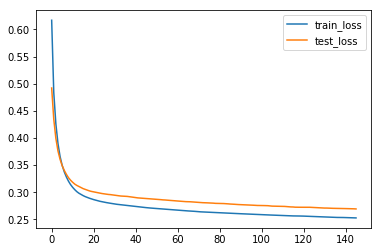

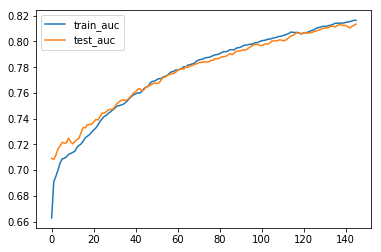

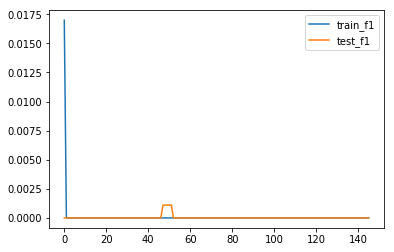

iter 155 train_loss 0.19826 test_loss 0.23156
iter 160 train_loss 0.19826 test_loss 0.23156
iter 165 train_loss 0.19826 test_loss 0.23156
iter 170 train_loss 0.19826 test_loss 0.23156
iter 175 train_loss 0.19826 test_loss 0.23156
iter 180 train_loss 0.19826 test_loss 0.23156
iter 185 train_loss 0.19826 test_loss 0.23156
iter 190 train_loss 0.19826 test_loss 0.23156
iter 195 train_loss 0.19826 test_loss 0.23156
iter 200 train_loss 0.19826 test_loss 0.23156


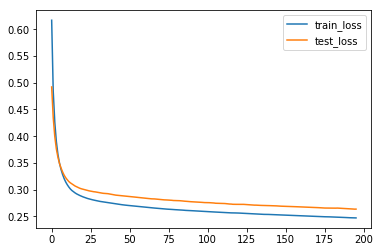

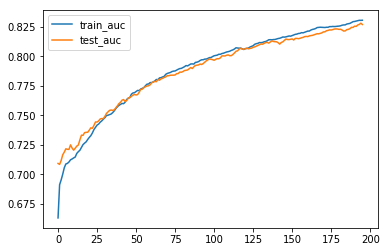

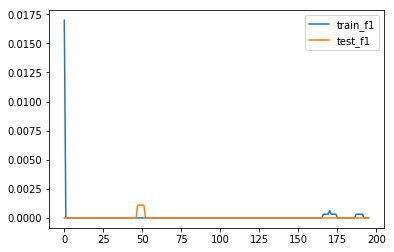

iter 205 train_loss 0.19826 test_loss 0.23156
iter 210 train_loss 0.19826 test_loss 0.23156
iter 215 train_loss 0.19826 test_loss 0.23156
iter 220 train_loss 0.19826 test_loss 0.23156
iter 225 train_loss 0.19826 test_loss 0.23156
iter 230 train_loss 0.19826 test_loss 0.23156
iter 235 train_loss 0.19826 test_loss 0.23156
iter 240 train_loss 0.19826 test_loss 0.23156
iter 245 train_loss 0.19826 test_loss 0.23156
iter 250 train_loss 0.19826 test_loss 0.23156


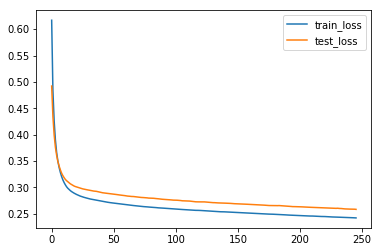

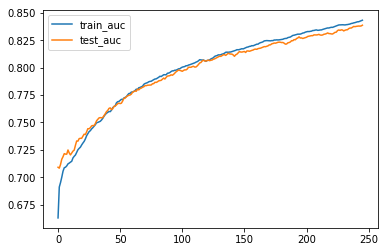

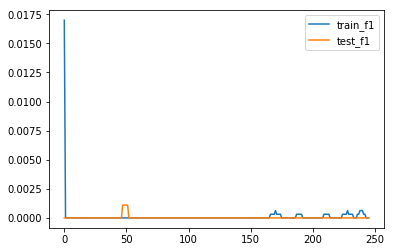

iter 255 train_loss 0.19826 test_loss 0.23156
iter 260 train_loss 0.19826 test_loss 0.23156
iter 265 train_loss 0.19826 test_loss 0.23156
iter 270 train_loss 0.19826 test_loss 0.23156
iter 275 train_loss 0.19826 test_loss 0.23156
iter 280 train_loss 0.19826 test_loss 0.23156
iter 285 train_loss 0.19826 test_loss 0.23156
iter 290 train_loss 0.19826 test_loss 0.23156
iter 295 train_loss 0.19826 test_loss 0.23156
iter 300 train_loss 0.19826 test_loss 0.23156


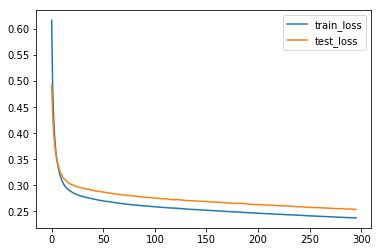

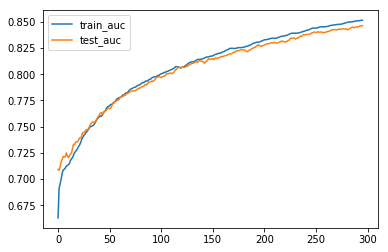

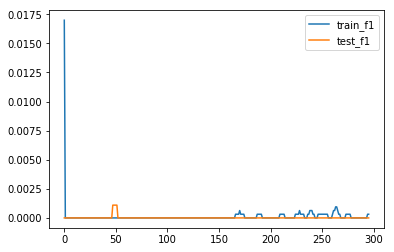

iter 305 train_loss 0.19826 test_loss 0.23156
iter 310 train_loss 0.19826 test_loss 0.23156
iter 315 train_loss 0.19826 test_loss 0.23156
iter 320 train_loss 0.19826 test_loss 0.23156
iter 325 train_loss 0.19826 test_loss 0.23156
iter 330 train_loss 0.19826 test_loss 0.23156
iter 335 train_loss 0.19826 test_loss 0.23156
iter 340 train_loss 0.19826 test_loss 0.23156
iter 345 train_loss 0.19826 test_loss 0.23156
iter 350 train_loss 0.19826 test_loss 0.23156


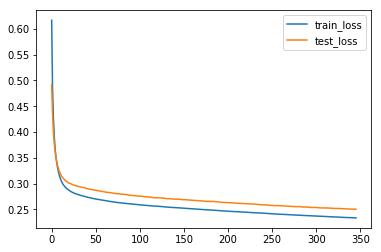

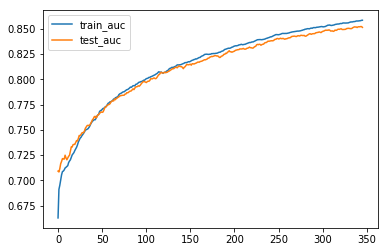

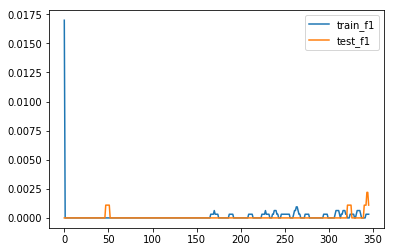

iter 355 train_loss 0.19826 test_loss 0.23156
iter 360 train_loss 0.19826 test_loss 0.23156
iter 365 train_loss 0.19826 test_loss 0.23156
iter 370 train_loss 0.19826 test_loss 0.23156
iter 375 train_loss 0.19826 test_loss 0.23156
iter 380 train_loss 0.19826 test_loss 0.23156
iter 385 train_loss 0.19826 test_loss 0.23156
iter 390 train_loss 0.19826 test_loss 0.23156
iter 395 train_loss 0.19826 test_loss 0.23156
iter 400 train_loss 0.19826 test_loss 0.23156


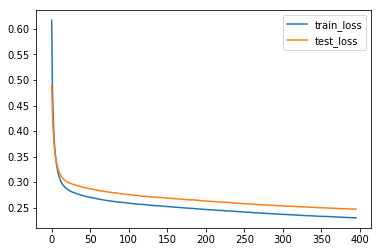

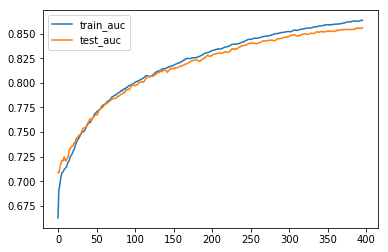

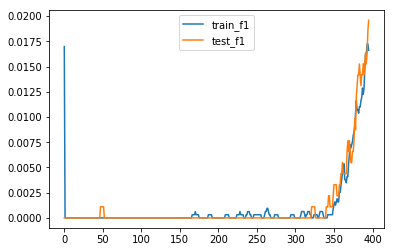

iter 405 train_loss 0.19826 test_loss 0.23156
iter 410 train_loss 0.19826 test_loss 0.23156
iter 415 train_loss 0.19826 test_loss 0.23156
iter 420 train_loss 0.19826 test_loss 0.23156
iter 425 train_loss 0.19826 test_loss 0.23156
iter 430 train_loss 0.19826 test_loss 0.23156
iter 435 train_loss 0.19826 test_loss 0.23156
iter 440 train_loss 0.19826 test_loss 0.23156
iter 445 train_loss 0.19826 test_loss 0.23156
iter 450 train_loss 0.19826 test_loss 0.23156


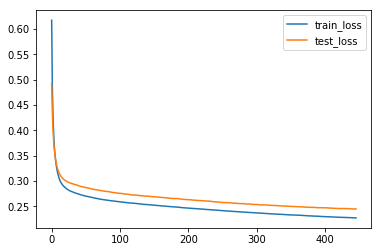

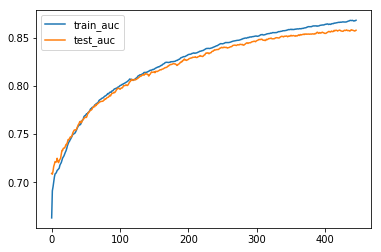

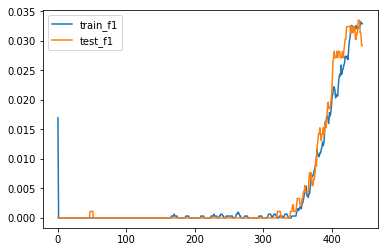

iter 455 train_loss 0.19826 test_loss 0.23156
iter 460 train_loss 0.19826 test_loss 0.23156
iter 465 train_loss 0.19826 test_loss 0.23156
iter 470 train_loss 0.19826 test_loss 0.23156
iter 475 train_loss 0.19826 test_loss 0.23156
iter 480 train_loss 0.19826 test_loss 0.23156
iter 485 train_loss 0.19826 test_loss 0.23156
iter 490 train_loss 0.19826 test_loss 0.23156
iter 495 train_loss 0.19826 test_loss 0.23156
iter 500 train_loss 0.19826 test_loss 0.23156


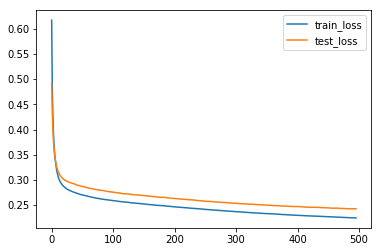

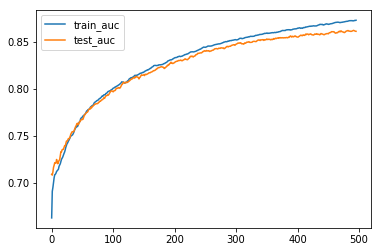

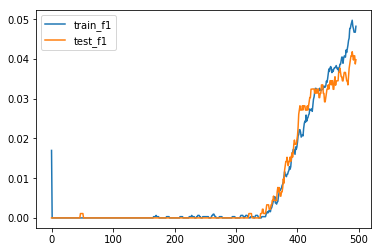

iter 505 train_loss 0.19826 test_loss 0.23156
iter 510 train_loss 0.19826 test_loss 0.23156
iter 515 train_loss 0.19826 test_loss 0.23156
iter 520 train_loss 0.19826 test_loss 0.23156
iter 525 train_loss 0.19826 test_loss 0.23156
iter 530 train_loss 0.19826 test_loss 0.23156
iter 535 train_loss 0.19826 test_loss 0.23156
iter 540 train_loss 0.19826 test_loss 0.23156
iter 545 train_loss 0.19826 test_loss 0.23156
iter 550 train_loss 0.19826 test_loss 0.23156


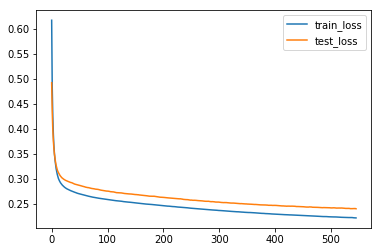

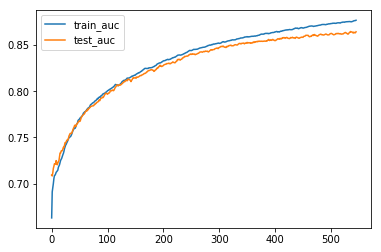

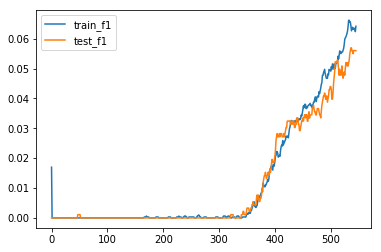

iter 555 train_loss 0.19826 test_loss 0.23156
iter 560 train_loss 0.19826 test_loss 0.23156
iter 565 train_loss 0.19826 test_loss 0.23156
iter 570 train_loss 0.19826 test_loss 0.23156
iter 575 train_loss 0.19826 test_loss 0.23156
iter 580 train_loss 0.19826 test_loss 0.23156
iter 585 train_loss 0.19826 test_loss 0.23156
iter 590 train_loss 0.19826 test_loss 0.23156
iter 595 train_loss 0.19826 test_loss 0.23156
iter 600 train_loss 0.19826 test_loss 0.23156


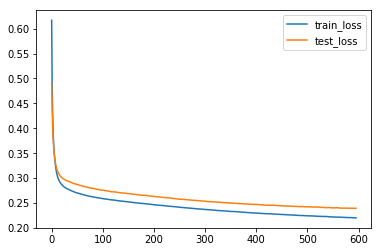

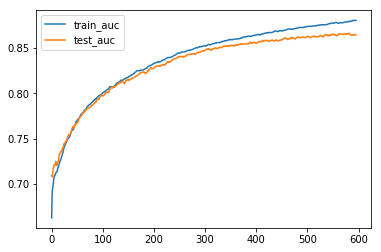

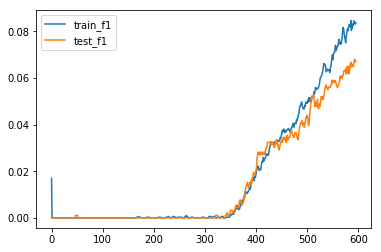

iter 605 train_loss 0.19826 test_loss 0.23156
iter 610 train_loss 0.19826 test_loss 0.23156
iter 615 train_loss 0.19826 test_loss 0.23156
iter 620 train_loss 0.19826 test_loss 0.23156
iter 625 train_loss 0.19826 test_loss 0.23156
iter 630 train_loss 0.19826 test_loss 0.23156
iter 635 train_loss 0.19826 test_loss 0.23156
iter 640 train_loss 0.19826 test_loss 0.23156
iter 645 train_loss 0.19826 test_loss 0.23156
iter 650 train_loss 0.19826 test_loss 0.23156


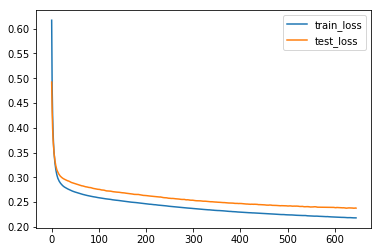

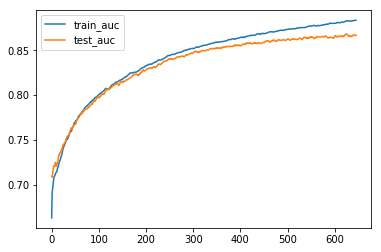

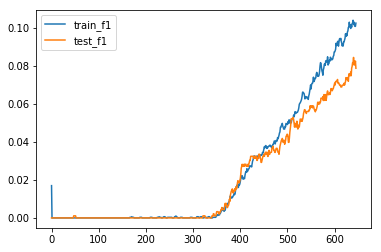

iter 655 train_loss 0.19826 test_loss 0.23156
iter 660 train_loss 0.19826 test_loss 0.23156
iter 665 train_loss 0.19826 test_loss 0.23156
iter 670 train_loss 0.19826 test_loss 0.23156
iter 675 train_loss 0.19826 test_loss 0.23156
iter 680 train_loss 0.19826 test_loss 0.23156
iter 685 train_loss 0.19826 test_loss 0.23156
iter 690 train_loss 0.19826 test_loss 0.23156
iter 695 train_loss 0.19826 test_loss 0.23156
iter 700 train_loss 0.19826 test_loss 0.23156


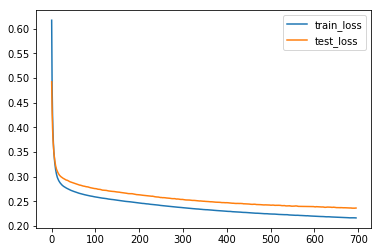

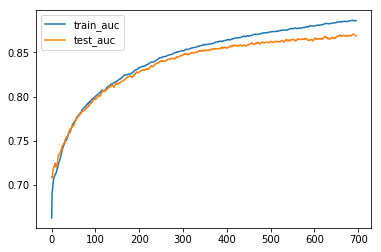

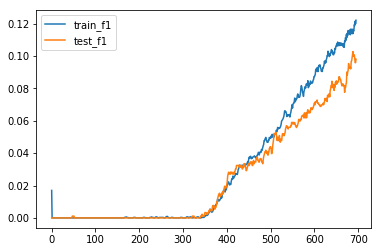

iter 705 train_loss 0.19826 test_loss 0.23156
iter 710 train_loss 0.19826 test_loss 0.23156
iter 715 train_loss 0.19826 test_loss 0.23156
iter 720 train_loss 0.19826 test_loss 0.23156
iter 725 train_loss 0.19826 test_loss 0.23156
iter 730 train_loss 0.19826 test_loss 0.23156
iter 735 train_loss 0.19826 test_loss 0.23156
iter 740 train_loss 0.19826 test_loss 0.23156
iter 745 train_loss 0.19826 test_loss 0.23156
iter 750 train_loss 0.19826 test_loss 0.23156


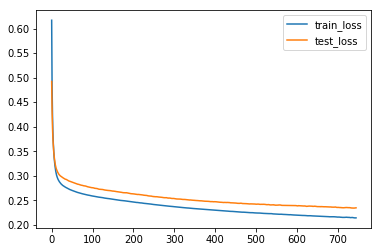

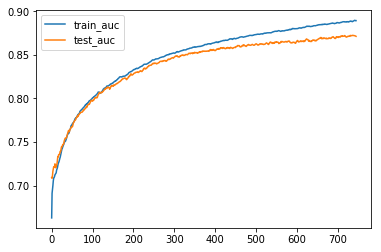

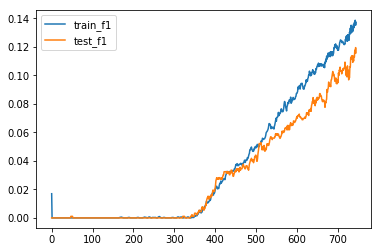

iter 755 train_loss 0.19826 test_loss 0.23156
iter 760 train_loss 0.19826 test_loss 0.23156
iter 765 train_loss 0.19826 test_loss 0.23156
iter 770 train_loss 0.19826 test_loss 0.23156
iter 775 train_loss 0.19826 test_loss 0.23156
iter 780 train_loss 0.19826 test_loss 0.23156
iter 785 train_loss 0.19826 test_loss 0.23156
iter 790 train_loss 0.19826 test_loss 0.23156
iter 795 train_loss 0.19826 test_loss 0.23156
iter 800 train_loss 0.19826 test_loss 0.23156


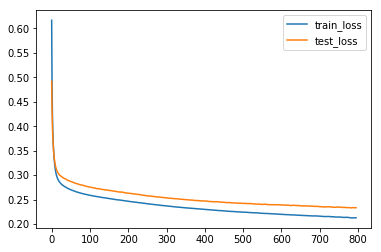

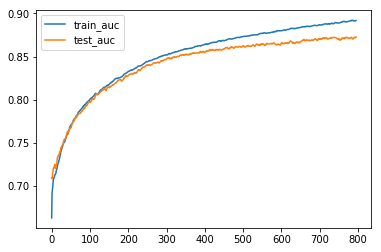

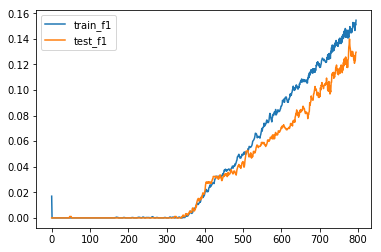

iter 805 train_loss 0.19826 test_loss 0.23156
iter 810 train_loss 0.19826 test_loss 0.23156
iter 815 train_loss 0.19826 test_loss 0.23156
iter 820 train_loss 0.19826 test_loss 0.23156
iter 825 train_loss 0.19826 test_loss 0.23156
iter 830 train_loss 0.19826 test_loss 0.23156
iter 835 train_loss 0.19826 test_loss 0.23156
iter 840 train_loss 0.19826 test_loss 0.23156
iter 845 train_loss 0.19826 test_loss 0.23156
iter 850 train_loss 0.19826 test_loss 0.23156


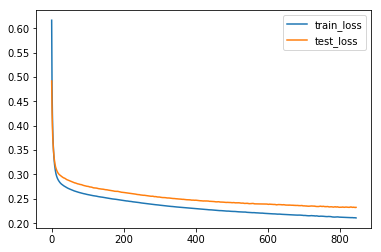

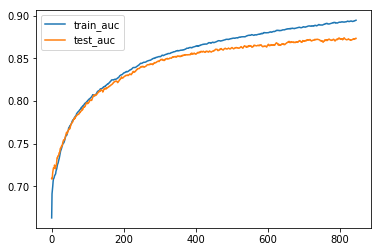

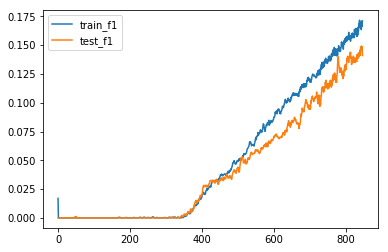

iter 855 train_loss 0.19826 test_loss 0.23156
iter 860 train_loss 0.19826 test_loss 0.23156
iter 865 train_loss 0.19826 test_loss 0.23156
iter 870 train_loss 0.19826 test_loss 0.23156
iter 875 train_loss 0.19826 test_loss 0.23156
iter 880 train_loss 0.19826 test_loss 0.23156
iter 885 train_loss 0.19826 test_loss 0.23156
iter 890 train_loss 0.19826 test_loss 0.23156
iter 895 train_loss 0.19826 test_loss 0.23156
iter 900 train_loss 0.19826 test_loss 0.23156


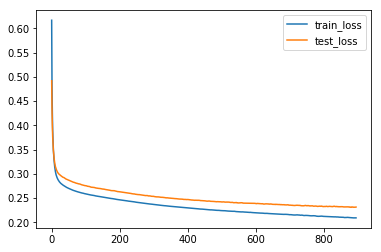

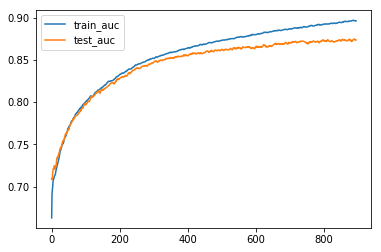

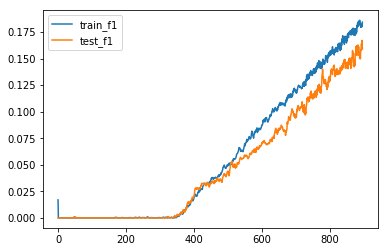

iter 905 train_loss 0.19826 test_loss 0.23156
iter 910 train_loss 0.19826 test_loss 0.23156
iter 915 train_loss 0.19826 test_loss 0.23156
iter 920 train_loss 0.19826 test_loss 0.23156
iter 925 train_loss 0.19826 test_loss 0.23156
iter 930 train_loss 0.19826 test_loss 0.23156
iter 935 train_loss 0.19826 test_loss 0.23156
iter 940 train_loss 0.19826 test_loss 0.23156
iter 945 train_loss 0.19826 test_loss 0.23156
iter 950 train_loss 0.19826 test_loss 0.23156


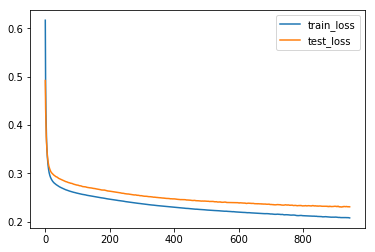

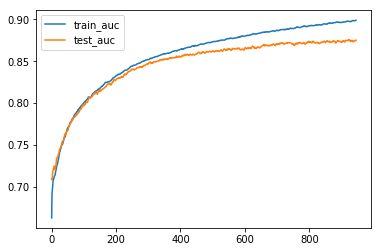

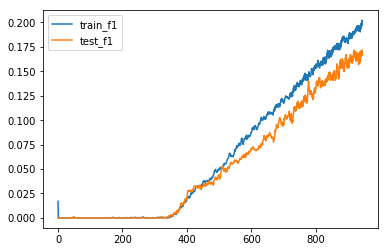

iter 955 train_loss 0.19826 test_loss 0.23156
iter 960 train_loss 0.19826 test_loss 0.23156
iter 965 train_loss 0.19826 test_loss 0.23156
iter 970 train_loss 0.19826 test_loss 0.23156
iter 975 train_loss 0.19826 test_loss 0.23156
iter 980 train_loss 0.19826 test_loss 0.23156
iter 985 train_loss 0.19826 test_loss 0.23156
iter 990 train_loss 0.19826 test_loss 0.23156
iter 995 train_loss 0.19826 test_loss 0.23156
iter 1000 train_loss 0.19826 test_loss 0.23156


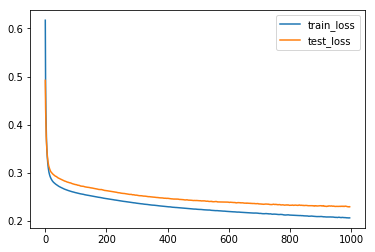

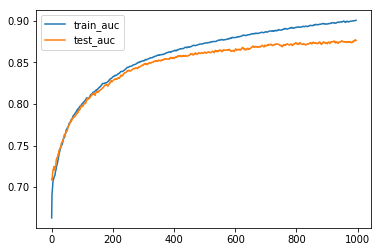

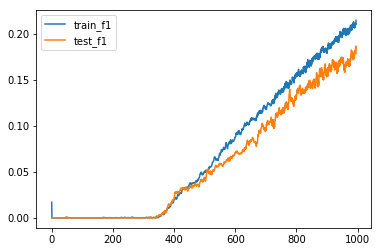

In [182]:
stats_noisy = train_model(model, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1005 train_loss 0.19826 test_loss 0.23156
iter 1010 train_loss 0.19826 test_loss 0.23156
iter 1015 train_loss 0.19826 test_loss 0.23156
iter 1020 train_loss 0.19826 test_loss 0.23156
iter 1025 train_loss 0.19826 test_loss 0.23156
iter 1030 train_loss 0.19826 test_loss 0.23156
iter 1035 train_loss 0.19826 test_loss 0.23156
iter 1040 train_loss 0.19826 test_loss 0.23156
iter 1045 train_loss 0.19826 test_loss 0.23156
iter 1050 train_loss 0.19826 test_loss 0.23156


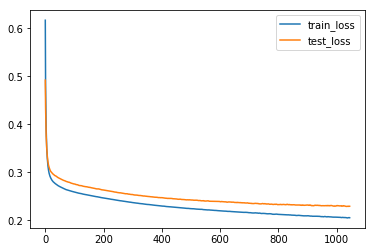

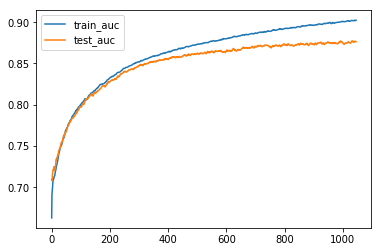

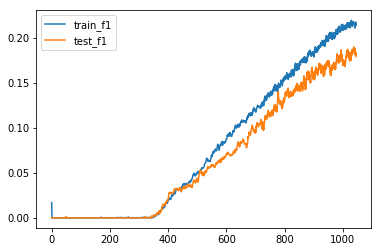

iter 1055 train_loss 0.19826 test_loss 0.23156
iter 1060 train_loss 0.19826 test_loss 0.23156
iter 1065 train_loss 0.19826 test_loss 0.23156
iter 1070 train_loss 0.19826 test_loss 0.23156
iter 1075 train_loss 0.19826 test_loss 0.23156
iter 1080 train_loss 0.19826 test_loss 0.23156
iter 1085 train_loss 0.19826 test_loss 0.23156
iter 1090 train_loss 0.19826 test_loss 0.23156
iter 1095 train_loss 0.19826 test_loss 0.23156
iter 1100 train_loss 0.19826 test_loss 0.23156


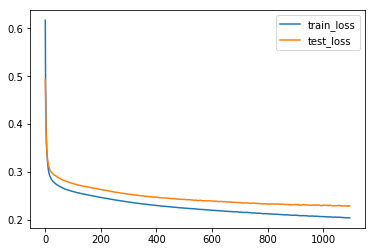

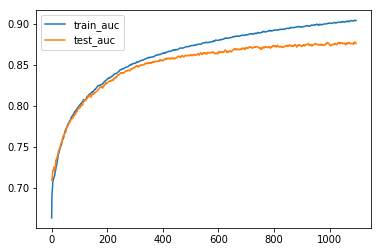

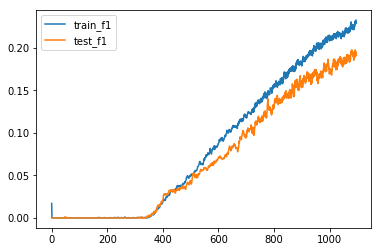

iter 1105 train_loss 0.19826 test_loss 0.23156
iter 1110 train_loss 0.19826 test_loss 0.23156
iter 1115 train_loss 0.19826 test_loss 0.23156
iter 1120 train_loss 0.19826 test_loss 0.23156
iter 1125 train_loss 0.19826 test_loss 0.23156
iter 1130 train_loss 0.19826 test_loss 0.23156
iter 1135 train_loss 0.19826 test_loss 0.23156
iter 1140 train_loss 0.19826 test_loss 0.23156
iter 1145 train_loss 0.19826 test_loss 0.23156
iter 1150 train_loss 0.19826 test_loss 0.23156


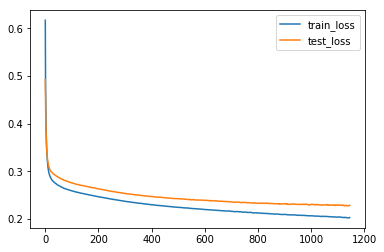

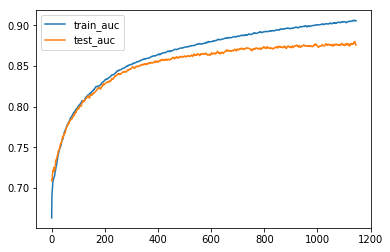

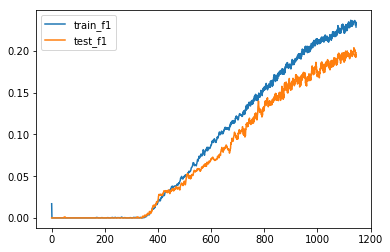

iter 1155 train_loss 0.19826 test_loss 0.23156
iter 1160 train_loss 0.19826 test_loss 0.23156
iter 1165 train_loss 0.19826 test_loss 0.23156
iter 1170 train_loss 0.19826 test_loss 0.23156
iter 1175 train_loss 0.19826 test_loss 0.23156
iter 1180 train_loss 0.19826 test_loss 0.23156
iter 1185 train_loss 0.19826 test_loss 0.23156
iter 1190 train_loss 0.19826 test_loss 0.23156
iter 1195 train_loss 0.19826 test_loss 0.23156
iter 1200 train_loss 0.19826 test_loss 0.23156


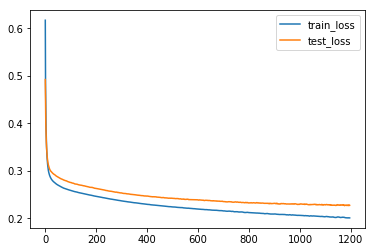

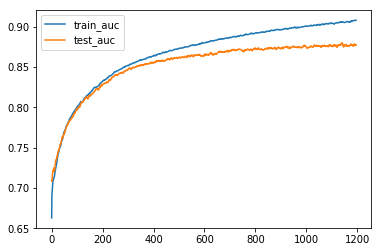

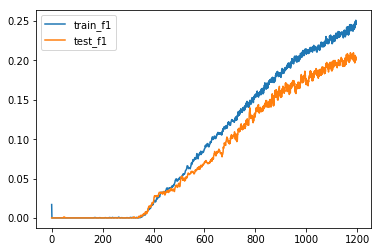

iter 1205 train_loss 0.19826 test_loss 0.23156
iter 1210 train_loss 0.19826 test_loss 0.23156
iter 1215 train_loss 0.19826 test_loss 0.23156
iter 1220 train_loss 0.19826 test_loss 0.23156
iter 1225 train_loss 0.19826 test_loss 0.23156
iter 1230 train_loss 0.19826 test_loss 0.23156
iter 1235 train_loss 0.19826 test_loss 0.23156
iter 1240 train_loss 0.19826 test_loss 0.23156
iter 1245 train_loss 0.19826 test_loss 0.23156
iter 1250 train_loss 0.19826 test_loss 0.23156


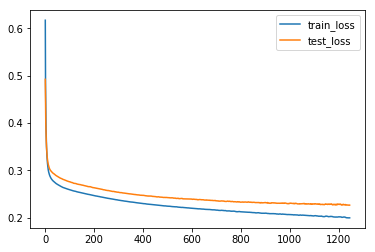

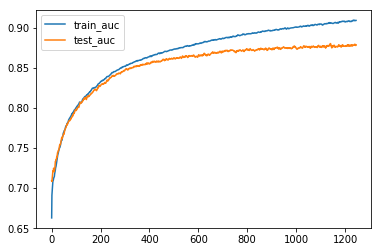

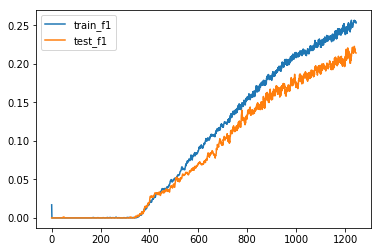

iter 1255 train_loss 0.19826 test_loss 0.23156
iter 1260 train_loss 0.19826 test_loss 0.23156
iter 1265 train_loss 0.19826 test_loss 0.23156
iter 1270 train_loss 0.19826 test_loss 0.23156
iter 1275 train_loss 0.19826 test_loss 0.23156
iter 1280 train_loss 0.19826 test_loss 0.23156
iter 1285 train_loss 0.19826 test_loss 0.23156
iter 1290 train_loss 0.19826 test_loss 0.23156
iter 1295 train_loss 0.19826 test_loss 0.23156
iter 1300 train_loss 0.19826 test_loss 0.23156


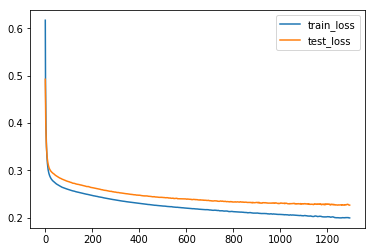

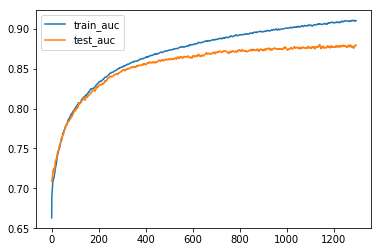

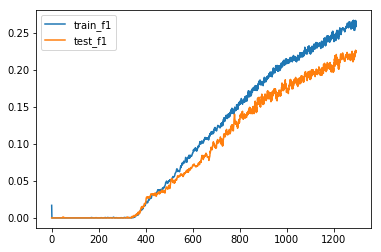

iter 1305 train_loss 0.19826 test_loss 0.23156
iter 1310 train_loss 0.19826 test_loss 0.23156
iter 1315 train_loss 0.19826 test_loss 0.23156
iter 1320 train_loss 0.19826 test_loss 0.23156
iter 1325 train_loss 0.19826 test_loss 0.23156
iter 1330 train_loss 0.19826 test_loss 0.23156
iter 1335 train_loss 0.19826 test_loss 0.23156
iter 1340 train_loss 0.19826 test_loss 0.23156
iter 1345 train_loss 0.19826 test_loss 0.23156
iter 1350 train_loss 0.19826 test_loss 0.23156


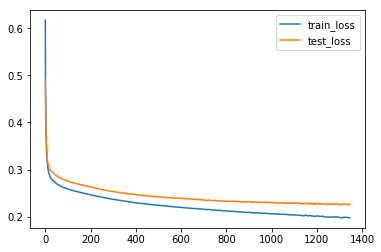

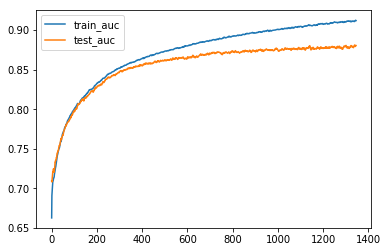

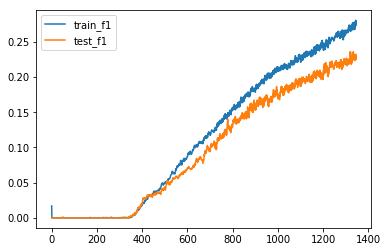

iter 1355 train_loss 0.19826 test_loss 0.23156
iter 1360 train_loss 0.19826 test_loss 0.23156
iter 1365 train_loss 0.19826 test_loss 0.23156
iter 1370 train_loss 0.19826 test_loss 0.23156
iter 1375 train_loss 0.19826 test_loss 0.23156
iter 1380 train_loss 0.19826 test_loss 0.23156
iter 1385 train_loss 0.19826 test_loss 0.23156
iter 1390 train_loss 0.19826 test_loss 0.23156
iter 1395 train_loss 0.19826 test_loss 0.23156
iter 1400 train_loss 0.19826 test_loss 0.23156


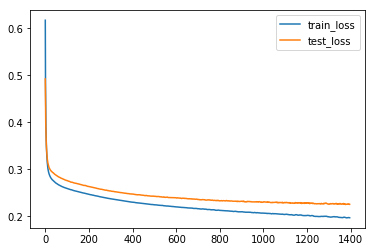

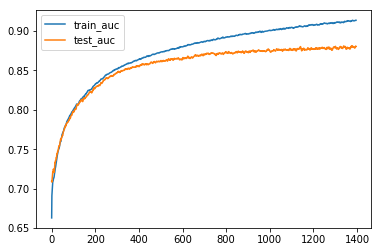

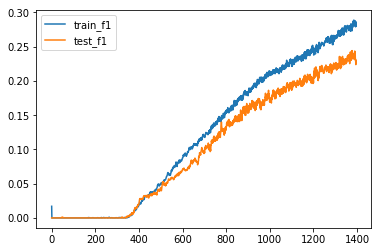

iter 1405 train_loss 0.19826 test_loss 0.23156
iter 1410 train_loss 0.19826 test_loss 0.23156
iter 1415 train_loss 0.19826 test_loss 0.23156
iter 1420 train_loss 0.19826 test_loss 0.23156
iter 1425 train_loss 0.19826 test_loss 0.23156
iter 1430 train_loss 0.19826 test_loss 0.23156
iter 1435 train_loss 0.19826 test_loss 0.23156
iter 1440 train_loss 0.19826 test_loss 0.23156
iter 1445 train_loss 0.19826 test_loss 0.23156
iter 1450 train_loss 0.19826 test_loss 0.23156


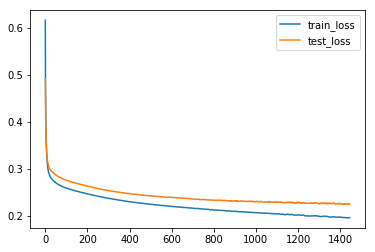

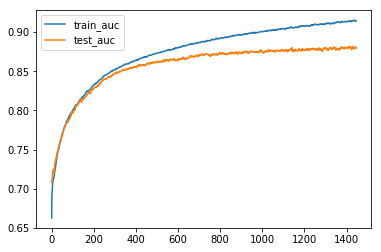

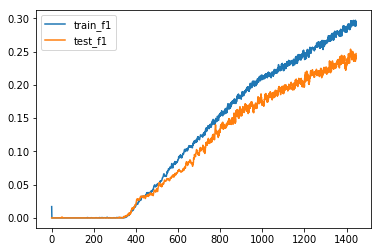

iter 1455 train_loss 0.19826 test_loss 0.23156
iter 1460 train_loss 0.19826 test_loss 0.23156
iter 1465 train_loss 0.19826 test_loss 0.23156
iter 1470 train_loss 0.19826 test_loss 0.23156
iter 1475 train_loss 0.19826 test_loss 0.23156
iter 1480 train_loss 0.19826 test_loss 0.23156
iter 1485 train_loss 0.19826 test_loss 0.23156
iter 1490 train_loss 0.19826 test_loss 0.23156
iter 1495 train_loss 0.19826 test_loss 0.23156
iter 1500 train_loss 0.19826 test_loss 0.23156


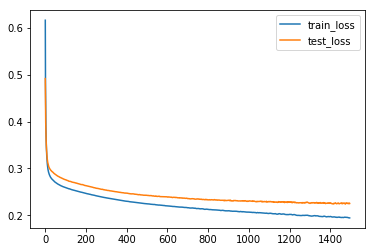

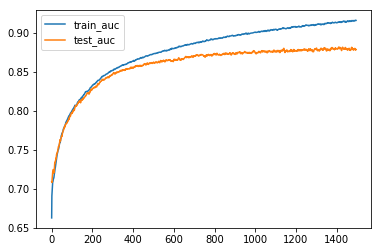

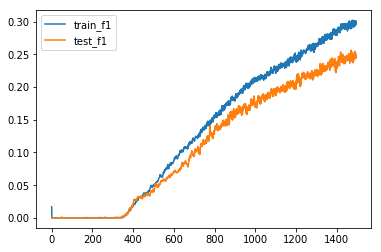

iter 1505 train_loss 0.19826 test_loss 0.23156
iter 1510 train_loss 0.19826 test_loss 0.23156
iter 1515 train_loss 0.19826 test_loss 0.23156
iter 1520 train_loss 0.19826 test_loss 0.23156
iter 1525 train_loss 0.19826 test_loss 0.23156
iter 1530 train_loss 0.19826 test_loss 0.23156
iter 1535 train_loss 0.19826 test_loss 0.23156
iter 1540 train_loss 0.19826 test_loss 0.23156
iter 1545 train_loss 0.19826 test_loss 0.23156
iter 1550 train_loss 0.19826 test_loss 0.23156


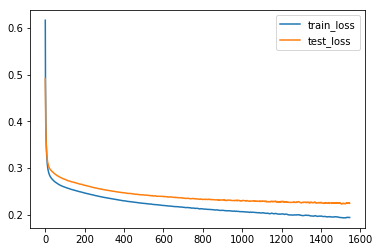

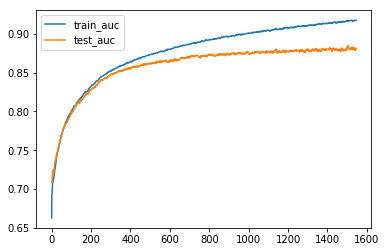

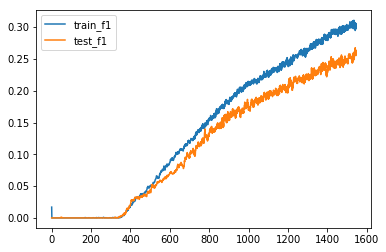

iter 1555 train_loss 0.19826 test_loss 0.23156
iter 1560 train_loss 0.19826 test_loss 0.23156
iter 1565 train_loss 0.19826 test_loss 0.23156
iter 1570 train_loss 0.19826 test_loss 0.23156
iter 1575 train_loss 0.19826 test_loss 0.23156
iter 1580 train_loss 0.19826 test_loss 0.23156
iter 1585 train_loss 0.19826 test_loss 0.23156
iter 1590 train_loss 0.19826 test_loss 0.23156
iter 1595 train_loss 0.19826 test_loss 0.23156
iter 1600 train_loss 0.19826 test_loss 0.23156


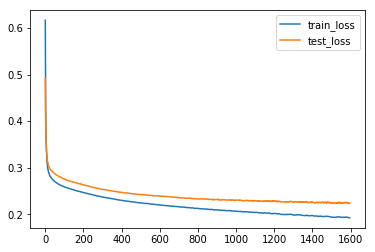

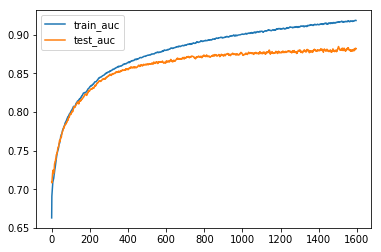

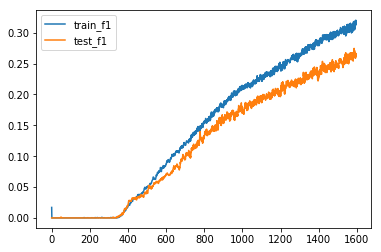

iter 1605 train_loss 0.19826 test_loss 0.23156
iter 1610 train_loss 0.19826 test_loss 0.23156
iter 1615 train_loss 0.19826 test_loss 0.23156
iter 1620 train_loss 0.19826 test_loss 0.23156
iter 1625 train_loss 0.19826 test_loss 0.23156
iter 1630 train_loss 0.19826 test_loss 0.23156
iter 1635 train_loss 0.19826 test_loss 0.23156
iter 1640 train_loss 0.19826 test_loss 0.23156
iter 1645 train_loss 0.19826 test_loss 0.23156
iter 1650 train_loss 0.19826 test_loss 0.23156


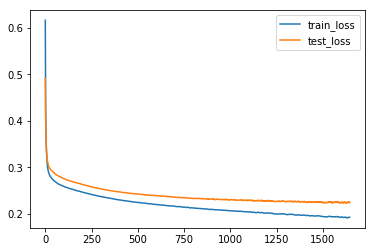

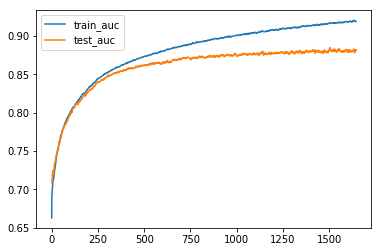

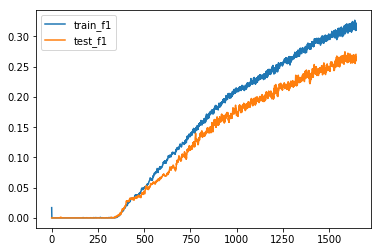

iter 1655 train_loss 0.19826 test_loss 0.23156
iter 1660 train_loss 0.19826 test_loss 0.23156
iter 1665 train_loss 0.19826 test_loss 0.23156
iter 1670 train_loss 0.19826 test_loss 0.23156
iter 1675 train_loss 0.19826 test_loss 0.23156
iter 1680 train_loss 0.19826 test_loss 0.23156
iter 1685 train_loss 0.19826 test_loss 0.23156
iter 1690 train_loss 0.19826 test_loss 0.23156
iter 1695 train_loss 0.19826 test_loss 0.23156
iter 1700 train_loss 0.19826 test_loss 0.23156


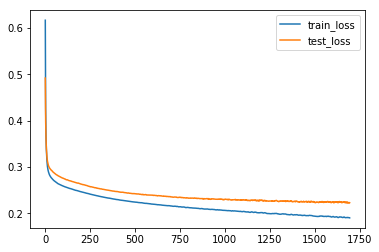

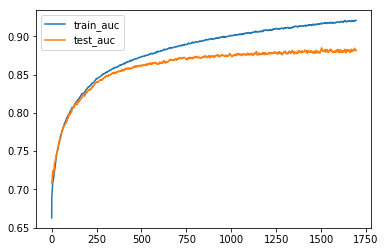

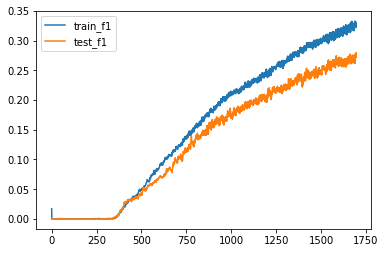

iter 1705 train_loss 0.19826 test_loss 0.23156
iter 1710 train_loss 0.19826 test_loss 0.23156
iter 1715 train_loss 0.19826 test_loss 0.23156
iter 1720 train_loss 0.19826 test_loss 0.23156
iter 1725 train_loss 0.19826 test_loss 0.23156
iter 1730 train_loss 0.19826 test_loss 0.23156
iter 1735 train_loss 0.19826 test_loss 0.23156
iter 1740 train_loss 0.19826 test_loss 0.23156
iter 1745 train_loss 0.19826 test_loss 0.23156
iter 1750 train_loss 0.19826 test_loss 0.23156


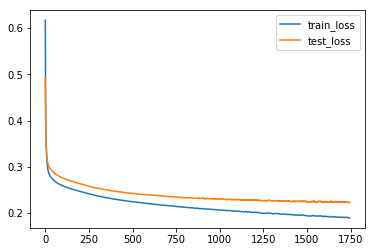

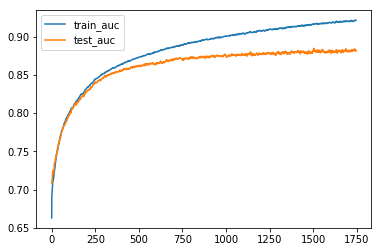

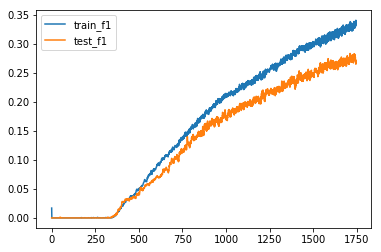

iter 1755 train_loss 0.19826 test_loss 0.23156
iter 1760 train_loss 0.19826 test_loss 0.23156
iter 1765 train_loss 0.19826 test_loss 0.23156
iter 1770 train_loss 0.19826 test_loss 0.23156
iter 1775 train_loss 0.19826 test_loss 0.23156
iter 1780 train_loss 0.19826 test_loss 0.23156
iter 1785 train_loss 0.19826 test_loss 0.23156
iter 1790 train_loss 0.19826 test_loss 0.23156
iter 1795 train_loss 0.19826 test_loss 0.23156
iter 1800 train_loss 0.19826 test_loss 0.23156


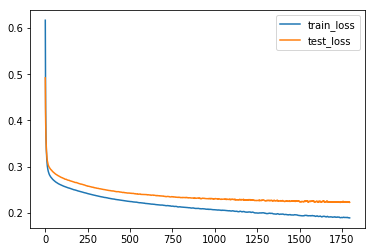

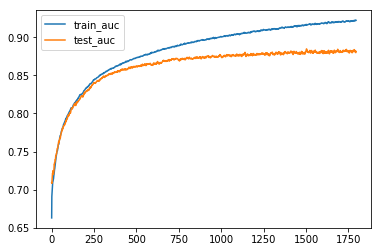

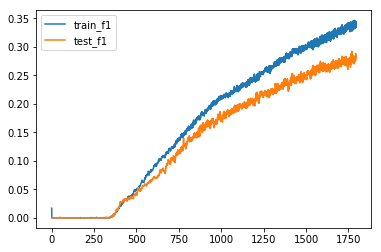

iter 1805 train_loss 0.19826 test_loss 0.23156
iter 1810 train_loss 0.19826 test_loss 0.23156
iter 1815 train_loss 0.19826 test_loss 0.23156
iter 1820 train_loss 0.19826 test_loss 0.23156
iter 1825 train_loss 0.19826 test_loss 0.23156
iter 1830 train_loss 0.19826 test_loss 0.23156
iter 1835 train_loss 0.19826 test_loss 0.23156
iter 1840 train_loss 0.19826 test_loss 0.23156
iter 1845 train_loss 0.19826 test_loss 0.23156
iter 1850 train_loss 0.19826 test_loss 0.23156


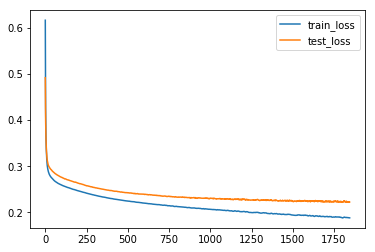

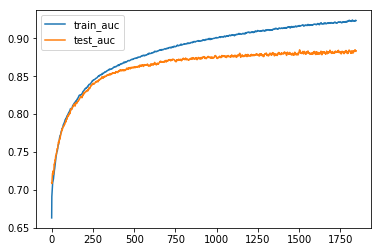

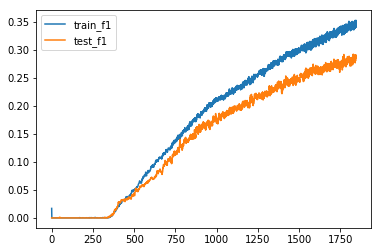

iter 1855 train_loss 0.19826 test_loss 0.23156
iter 1860 train_loss 0.19826 test_loss 0.23156
iter 1865 train_loss 0.19826 test_loss 0.23156
iter 1870 train_loss 0.19826 test_loss 0.23156
iter 1875 train_loss 0.19826 test_loss 0.23156
iter 1880 train_loss 0.19826 test_loss 0.23156
iter 1885 train_loss 0.19826 test_loss 0.23156
iter 1890 train_loss 0.19826 test_loss 0.23156
iter 1895 train_loss 0.19826 test_loss 0.23156
iter 1900 train_loss 0.19826 test_loss 0.23156


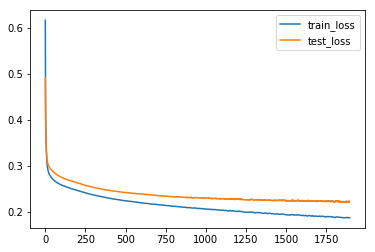

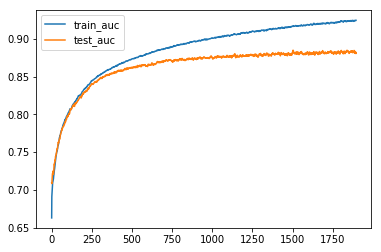

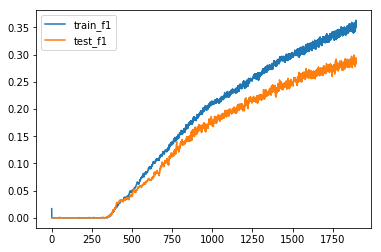

iter 1905 train_loss 0.19826 test_loss 0.23156
iter 1910 train_loss 0.19826 test_loss 0.23156
iter 1915 train_loss 0.19826 test_loss 0.23156
iter 1920 train_loss 0.19826 test_loss 0.23156
iter 1925 train_loss 0.19826 test_loss 0.23156
iter 1930 train_loss 0.19826 test_loss 0.23156
iter 1935 train_loss 0.19826 test_loss 0.23156
iter 1940 train_loss 0.19826 test_loss 0.23156
iter 1945 train_loss 0.19826 test_loss 0.23156
iter 1950 train_loss 0.19826 test_loss 0.23156


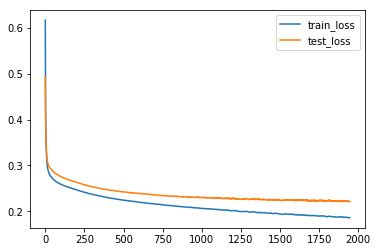

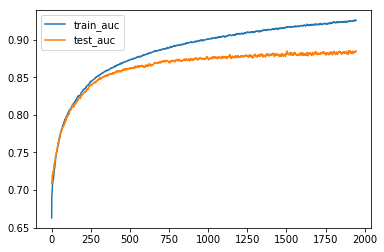

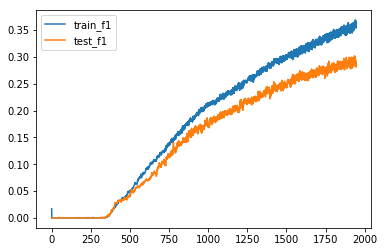

iter 1955 train_loss 0.19826 test_loss 0.23156
iter 1960 train_loss 0.19826 test_loss 0.23156
iter 1965 train_loss 0.19826 test_loss 0.23156
iter 1970 train_loss 0.19826 test_loss 0.23156
iter 1975 train_loss 0.19826 test_loss 0.23156
iter 1980 train_loss 0.19826 test_loss 0.23156
iter 1985 train_loss 0.19826 test_loss 0.23156
iter 1990 train_loss 0.19826 test_loss 0.23156
iter 1995 train_loss 0.19826 test_loss 0.23156
iter 2000 train_loss 0.19826 test_loss 0.23156


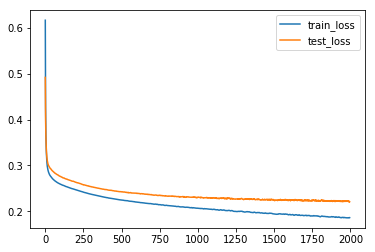

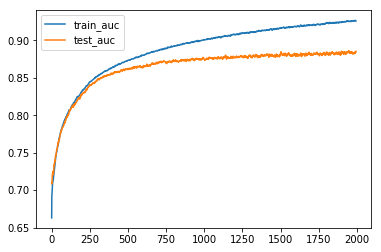

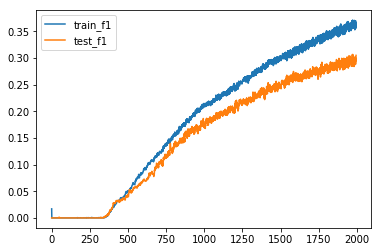

In [183]:
train_model(model, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

iter 2005 train_loss 0.19826 test_loss 0.23156
iter 2010 train_loss 0.19826 test_loss 0.23156
iter 2015 train_loss 0.19826 test_loss 0.23156
iter 2020 train_loss 0.19826 test_loss 0.23156
iter 2025 train_loss 0.19826 test_loss 0.23156
iter 2030 train_loss 0.19826 test_loss 0.23156
iter 2035 train_loss 0.19826 test_loss 0.23156
iter 2040 train_loss 0.19826 test_loss 0.23156
iter 2045 train_loss 0.19826 test_loss 0.23156
iter 2050 train_loss 0.19826 test_loss 0.23156


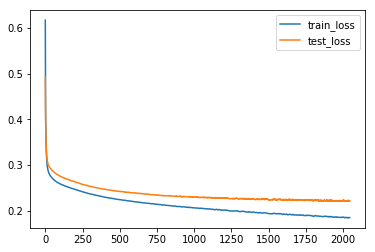

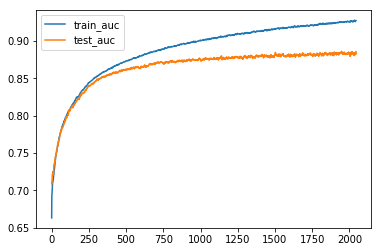

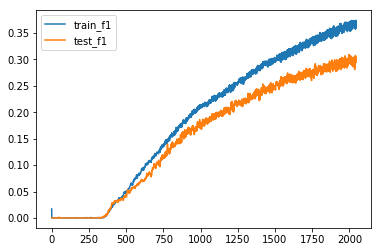

iter 2055 train_loss 0.19826 test_loss 0.23156
iter 2060 train_loss 0.19826 test_loss 0.23156
iter 2065 train_loss 0.19826 test_loss 0.23156
iter 2070 train_loss 0.19826 test_loss 0.23156
iter 2075 train_loss 0.19826 test_loss 0.23156
iter 2080 train_loss 0.19826 test_loss 0.23156
iter 2085 train_loss 0.19826 test_loss 0.23156
iter 2090 train_loss 0.19826 test_loss 0.23156
iter 2095 train_loss 0.19826 test_loss 0.23156
iter 2100 train_loss 0.19826 test_loss 0.23156


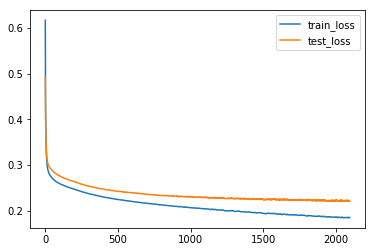

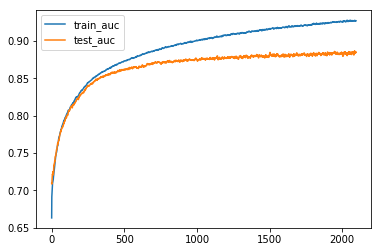

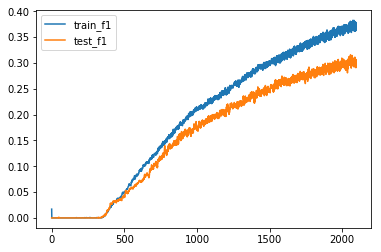

iter 2105 train_loss 0.19826 test_loss 0.23156
iter 2110 train_loss 0.19826 test_loss 0.23156
iter 2115 train_loss 0.19826 test_loss 0.23156
iter 2120 train_loss 0.19826 test_loss 0.23156
iter 2125 train_loss 0.19826 test_loss 0.23156
iter 2130 train_loss 0.19826 test_loss 0.23156
iter 2135 train_loss 0.19826 test_loss 0.23156
iter 2140 train_loss 0.19826 test_loss 0.23156
iter 2145 train_loss 0.19826 test_loss 0.23156
iter 2150 train_loss 0.19826 test_loss 0.23156


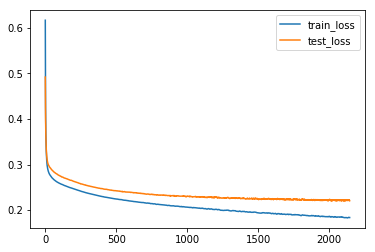

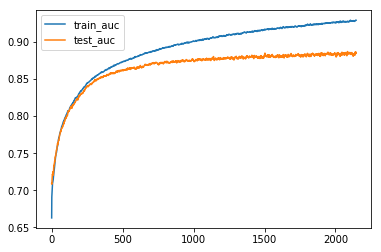

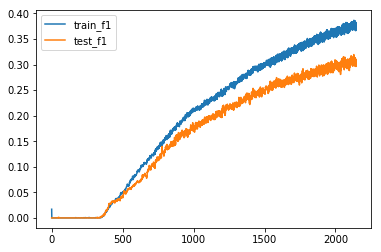

iter 2155 train_loss 0.19826 test_loss 0.23156
iter 2160 train_loss 0.19826 test_loss 0.23156
iter 2165 train_loss 0.19826 test_loss 0.23156
iter 2170 train_loss 0.19826 test_loss 0.23156
iter 2175 train_loss 0.19826 test_loss 0.23156
iter 2180 train_loss 0.19826 test_loss 0.23156
iter 2185 train_loss 0.19826 test_loss 0.23156
iter 2190 train_loss 0.19826 test_loss 0.23156
iter 2195 train_loss 0.19826 test_loss 0.23156
iter 2200 train_loss 0.19826 test_loss 0.23156


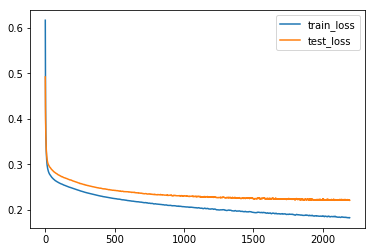

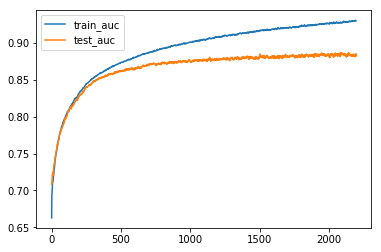

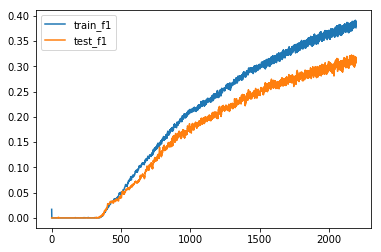

iter 2205 train_loss 0.19826 test_loss 0.23156
iter 2210 train_loss 0.19826 test_loss 0.23156
iter 2215 train_loss 0.19826 test_loss 0.23156
iter 2220 train_loss 0.19826 test_loss 0.23156
iter 2225 train_loss 0.19826 test_loss 0.23156
iter 2230 train_loss 0.19826 test_loss 0.23156
iter 2235 train_loss 0.19826 test_loss 0.23156
iter 2240 train_loss 0.19826 test_loss 0.23156
iter 2245 train_loss 0.19826 test_loss 0.23156
iter 2250 train_loss 0.19826 test_loss 0.23156


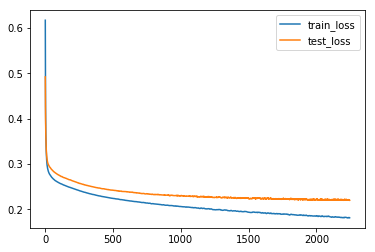

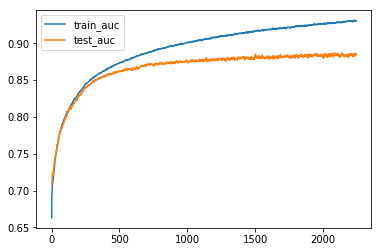

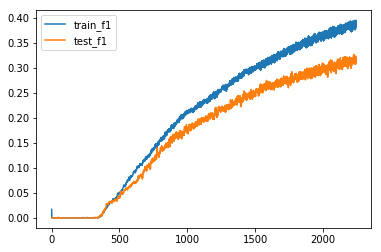

iter 2255 train_loss 0.19826 test_loss 0.23156
iter 2260 train_loss 0.19826 test_loss 0.23156
iter 2265 train_loss 0.19826 test_loss 0.23156
iter 2270 train_loss 0.19826 test_loss 0.23156
iter 2275 train_loss 0.19826 test_loss 0.23156
iter 2280 train_loss 0.19826 test_loss 0.23156
iter 2285 train_loss 0.19826 test_loss 0.23156
iter 2290 train_loss 0.19826 test_loss 0.23156
iter 2295 train_loss 0.19826 test_loss 0.23156
iter 2300 train_loss 0.19826 test_loss 0.23156


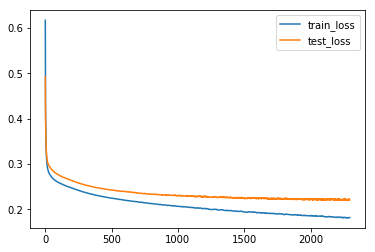

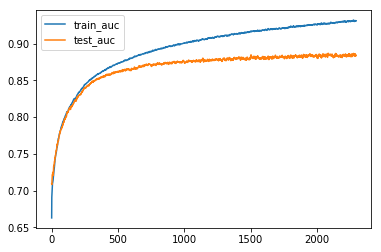

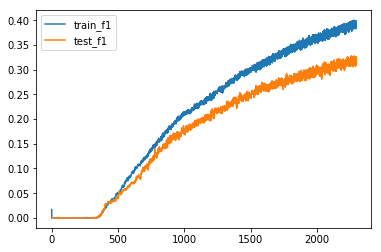

iter 2305 train_loss 0.19826 test_loss 0.23156
iter 2310 train_loss 0.19826 test_loss 0.23156
iter 2315 train_loss 0.19826 test_loss 0.23156
iter 2320 train_loss 0.19826 test_loss 0.23156
iter 2325 train_loss 0.19826 test_loss 0.23156
iter 2330 train_loss 0.19826 test_loss 0.23156
iter 2335 train_loss 0.19826 test_loss 0.23156
iter 2340 train_loss 0.19826 test_loss 0.23156
iter 2345 train_loss 0.19826 test_loss 0.23156
iter 2350 train_loss 0.19826 test_loss 0.23156


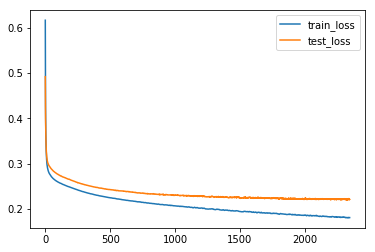

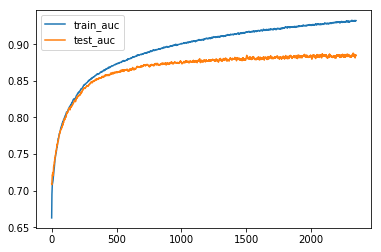

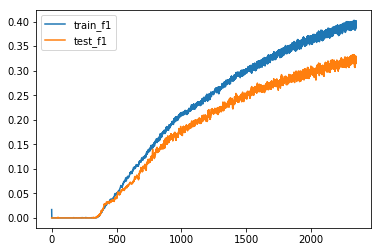

iter 2355 train_loss 0.19826 test_loss 0.23156
iter 2360 train_loss 0.19826 test_loss 0.23156
iter 2365 train_loss 0.19826 test_loss 0.23156
iter 2370 train_loss 0.19826 test_loss 0.23156
iter 2375 train_loss 0.19826 test_loss 0.23156
iter 2380 train_loss 0.19826 test_loss 0.23156
iter 2385 train_loss 0.19826 test_loss 0.23156
iter 2390 train_loss 0.19826 test_loss 0.23156
iter 2395 train_loss 0.19826 test_loss 0.23156
iter 2400 train_loss 0.19826 test_loss 0.23156


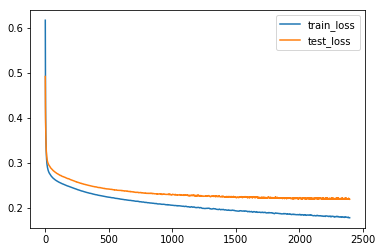

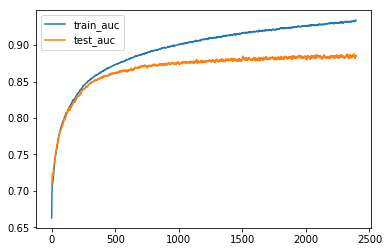

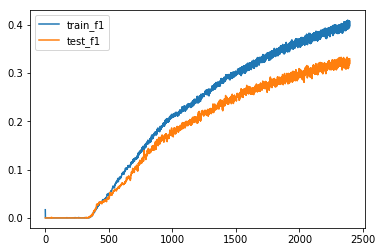

iter 2405 train_loss 0.19826 test_loss 0.23156
iter 2410 train_loss 0.19826 test_loss 0.23156
iter 2415 train_loss 0.19826 test_loss 0.23156
iter 2420 train_loss 0.19826 test_loss 0.23156
iter 2425 train_loss 0.19826 test_loss 0.23156
iter 2430 train_loss 0.19826 test_loss 0.23156
iter 2435 train_loss 0.19826 test_loss 0.23156
iter 2440 train_loss 0.19826 test_loss 0.23156
iter 2445 train_loss 0.19826 test_loss 0.23156
iter 2450 train_loss 0.19826 test_loss 0.23156


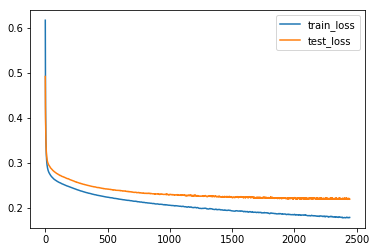

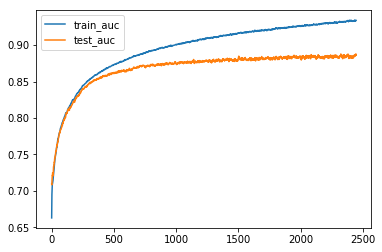

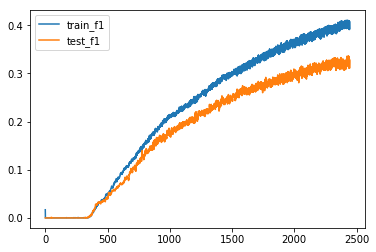

iter 2455 train_loss 0.19826 test_loss 0.23156
iter 2460 train_loss 0.19826 test_loss 0.23156
iter 2465 train_loss 0.19826 test_loss 0.23156
iter 2470 train_loss 0.19826 test_loss 0.23156
iter 2475 train_loss 0.19826 test_loss 0.23156
iter 2480 train_loss 0.19826 test_loss 0.23156
iter 2485 train_loss 0.19826 test_loss 0.23156
iter 2490 train_loss 0.19826 test_loss 0.23156
iter 2495 train_loss 0.19826 test_loss 0.23156
iter 2500 train_loss 0.19826 test_loss 0.23156


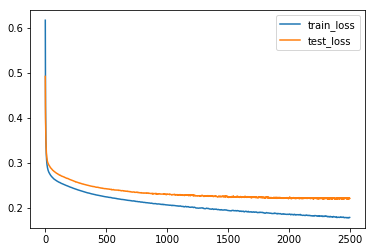

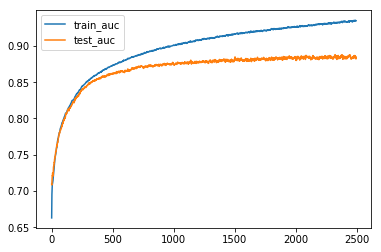

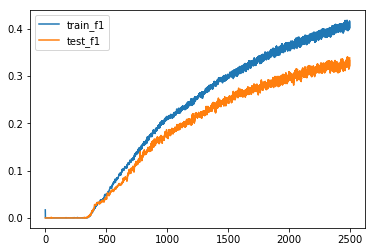

iter 2505 train_loss 0.19826 test_loss 0.23156
iter 2510 train_loss 0.19826 test_loss 0.23156
iter 2515 train_loss 0.19826 test_loss 0.23156
iter 2520 train_loss 0.19826 test_loss 0.23156
iter 2525 train_loss 0.19826 test_loss 0.23156
iter 2530 train_loss 0.19826 test_loss 0.23156
iter 2535 train_loss 0.19826 test_loss 0.23156
iter 2540 train_loss 0.19826 test_loss 0.23156
iter 2545 train_loss 0.19826 test_loss 0.23156
iter 2550 train_loss 0.19826 test_loss 0.23156


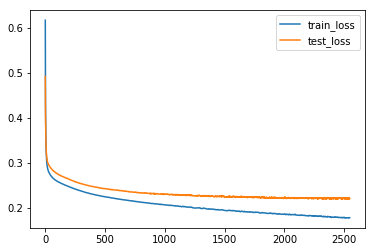

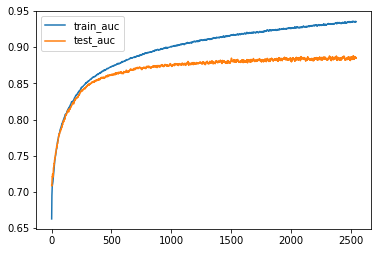

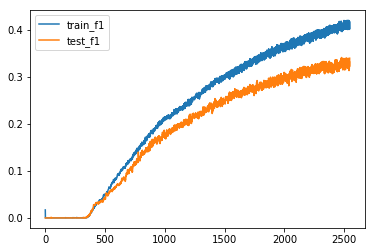

iter 2555 train_loss 0.19826 test_loss 0.23156
iter 2560 train_loss 0.19826 test_loss 0.23156
iter 2565 train_loss 0.19826 test_loss 0.23156
iter 2570 train_loss 0.19826 test_loss 0.23156
iter 2575 train_loss 0.19826 test_loss 0.23156
iter 2580 train_loss 0.19826 test_loss 0.23156
iter 2585 train_loss 0.19826 test_loss 0.23156
iter 2590 train_loss 0.19826 test_loss 0.23156
iter 2595 train_loss 0.19826 test_loss 0.23156
iter 2600 train_loss 0.19826 test_loss 0.23156


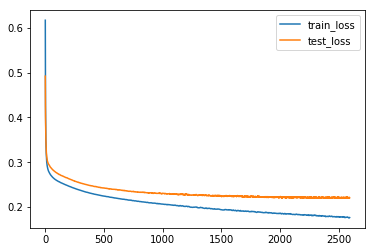

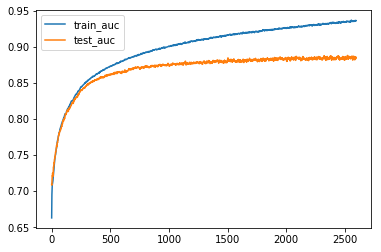

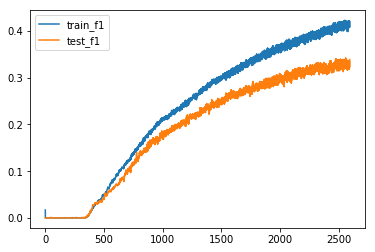

iter 2605 train_loss 0.19826 test_loss 0.23156
iter 2610 train_loss 0.19826 test_loss 0.23156
iter 2615 train_loss 0.19826 test_loss 0.23156
iter 2620 train_loss 0.19826 test_loss 0.23156
iter 2625 train_loss 0.19826 test_loss 0.23156
iter 2630 train_loss 0.19826 test_loss 0.23156
iter 2635 train_loss 0.19826 test_loss 0.23156
iter 2640 train_loss 0.19826 test_loss 0.23156
iter 2645 train_loss 0.19826 test_loss 0.23156
iter 2650 train_loss 0.19826 test_loss 0.23156


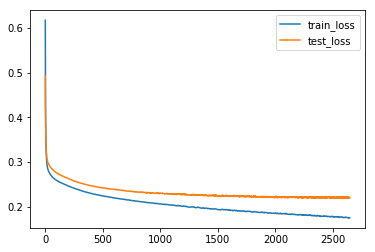

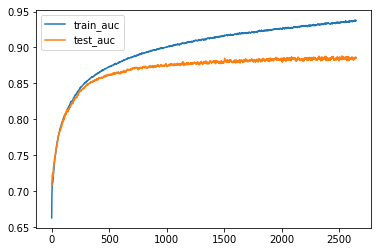

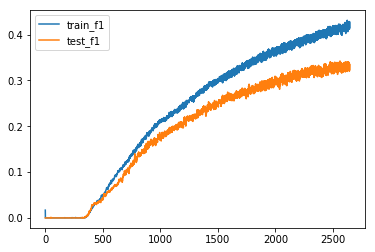

iter 2655 train_loss 0.19826 test_loss 0.23156
iter 2660 train_loss 0.19826 test_loss 0.23156
iter 2665 train_loss 0.19826 test_loss 0.23156
iter 2670 train_loss 0.19826 test_loss 0.23156
iter 2675 train_loss 0.19826 test_loss 0.23156
iter 2680 train_loss 0.19826 test_loss 0.23156
iter 2685 train_loss 0.19826 test_loss 0.23156
iter 2690 train_loss 0.19826 test_loss 0.23156
iter 2695 train_loss 0.19826 test_loss 0.23156
iter 2700 train_loss 0.19826 test_loss 0.23156


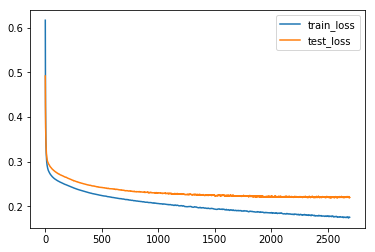

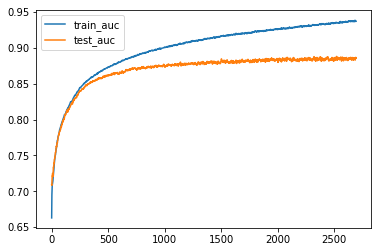

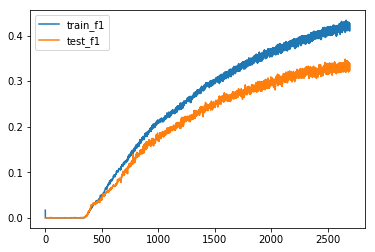

iter 2705 train_loss 0.19826 test_loss 0.23156
iter 2710 train_loss 0.19826 test_loss 0.23156
iter 2715 train_loss 0.19826 test_loss 0.23156
iter 2720 train_loss 0.19826 test_loss 0.23156
iter 2725 train_loss 0.19826 test_loss 0.23156
iter 2730 train_loss 0.19826 test_loss 0.23156
iter 2735 train_loss 0.19826 test_loss 0.23156
iter 2740 train_loss 0.19826 test_loss 0.23156
iter 2745 train_loss 0.19826 test_loss 0.23156
iter 2750 train_loss 0.19826 test_loss 0.23156


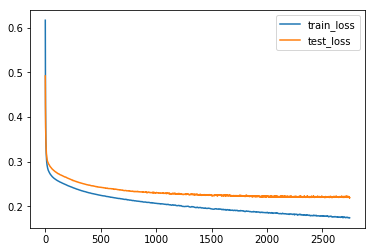

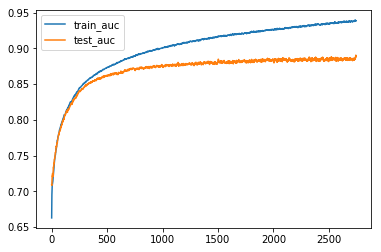

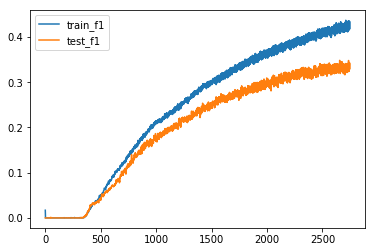

iter 2755 train_loss 0.19826 test_loss 0.23156
iter 2760 train_loss 0.19826 test_loss 0.23156
iter 2765 train_loss 0.19826 test_loss 0.23156
iter 2770 train_loss 0.19826 test_loss 0.23156
iter 2775 train_loss 0.19826 test_loss 0.23156
iter 2780 train_loss 0.19826 test_loss 0.23156
iter 2785 train_loss 0.19826 test_loss 0.23156
iter 2790 train_loss 0.19826 test_loss 0.23156
iter 2795 train_loss 0.19826 test_loss 0.23156
iter 2800 train_loss 0.19826 test_loss 0.23156


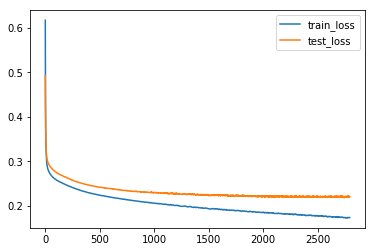

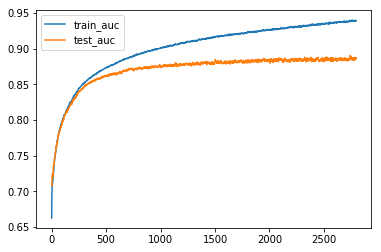

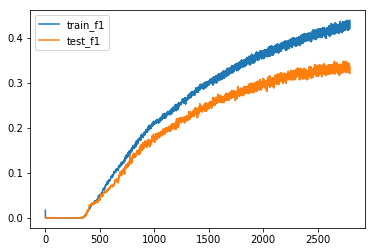

iter 2805 train_loss 0.19826 test_loss 0.23156
iter 2810 train_loss 0.19826 test_loss 0.23156
iter 2815 train_loss 0.19826 test_loss 0.23156
iter 2820 train_loss 0.19826 test_loss 0.23156
iter 2825 train_loss 0.19826 test_loss 0.23156
iter 2830 train_loss 0.19826 test_loss 0.23156
iter 2835 train_loss 0.19826 test_loss 0.23156
iter 2840 train_loss 0.19826 test_loss 0.23156
iter 2845 train_loss 0.19826 test_loss 0.23156
iter 2850 train_loss 0.19826 test_loss 0.23156


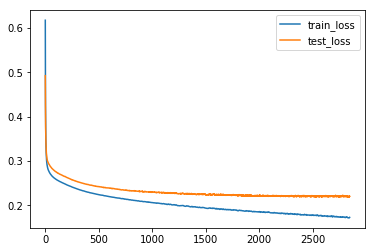

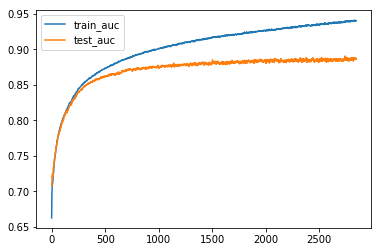

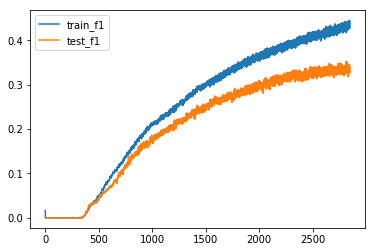

iter 2855 train_loss 0.19826 test_loss 0.23156
iter 2860 train_loss 0.19826 test_loss 0.23156
iter 2865 train_loss 0.19826 test_loss 0.23156
iter 2870 train_loss 0.19826 test_loss 0.23156
iter 2875 train_loss 0.19826 test_loss 0.23156
iter 2880 train_loss 0.19826 test_loss 0.23156
iter 2885 train_loss 0.19826 test_loss 0.23156
iter 2890 train_loss 0.19826 test_loss 0.23156
iter 2895 train_loss 0.19826 test_loss 0.23156
iter 2900 train_loss 0.19826 test_loss 0.23156


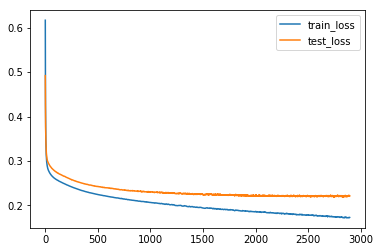

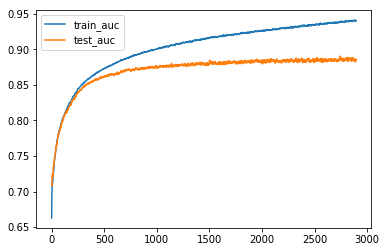

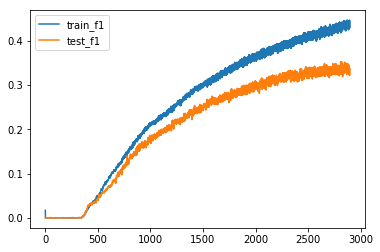

iter 2905 train_loss 0.19826 test_loss 0.23156
iter 2910 train_loss 0.19826 test_loss 0.23156
iter 2915 train_loss 0.19826 test_loss 0.23156
iter 2920 train_loss 0.19826 test_loss 0.23156
iter 2925 train_loss 0.19826 test_loss 0.23156
iter 2930 train_loss 0.19826 test_loss 0.23156
iter 2935 train_loss 0.19826 test_loss 0.23156
iter 2940 train_loss 0.19826 test_loss 0.23156
iter 2945 train_loss 0.19826 test_loss 0.23156
iter 2950 train_loss 0.19826 test_loss 0.23156


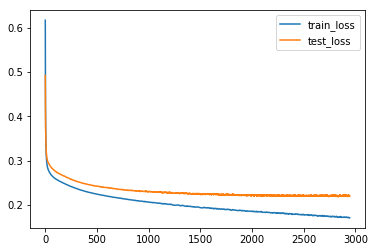

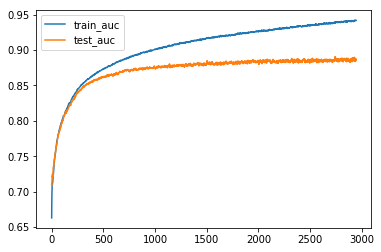

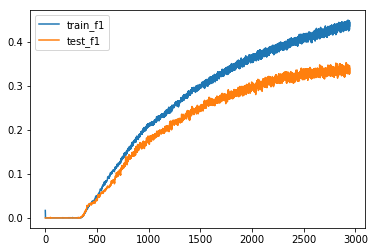

iter 2955 train_loss 0.19826 test_loss 0.23156
iter 2960 train_loss 0.19826 test_loss 0.23156
iter 2965 train_loss 0.19826 test_loss 0.23156
iter 2970 train_loss 0.19826 test_loss 0.23156
iter 2975 train_loss 0.19826 test_loss 0.23156
iter 2980 train_loss 0.19826 test_loss 0.23156
iter 2985 train_loss 0.19826 test_loss 0.23156
iter 2990 train_loss 0.19826 test_loss 0.23156
iter 2995 train_loss 0.19826 test_loss 0.23156
iter 3000 train_loss 0.19826 test_loss 0.23156


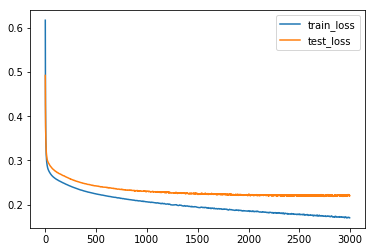

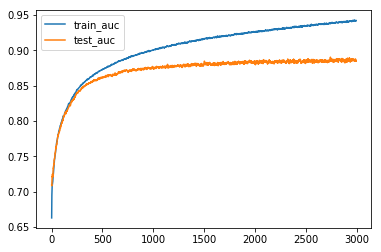

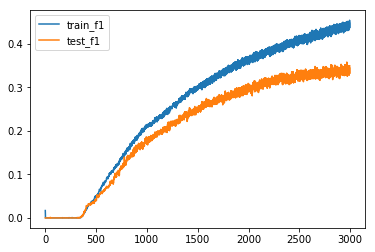

In [184]:
train_model(model, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)